In [712]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [671]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [672]:
def f(x, category):
    if category == 0:
        noise = -50 * torch.rand(1)
    elif category == 1:
        noise = 50 * torch.rand(1)
        
    return x.pow(3) + 2*x.pow(2) + 3*x + noise

In [674]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden_2, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden,n_hidden_2)
        self.predict = torch.nn.Linear(n_hidden_2, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x


In [675]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [676]:
def sample_dataset(sample_size):
    inputs_0 = torch.unsqueeze(torch.linspace(-5, 5, sample_size), dim=1)
    inputs_1 = torch.unsqueeze(torch.linspace(-4.5, 5.5, sample_size), dim=1)
    all_inputs = torch.cat((inputs_0,inputs_1))
    outputs_0 = f(inputs_0, 0)
    outputs_1 = f(inputs_1, 1)
    X = torch.cat((outputs_0, outputs_1))
    Y_0 = torch.zeros(sample_size)
    Y_1 = torch.ones(sample_size)
    Y = torch.hstack((Y_0,Y_1)).long()
    net_in = torch.hstack((all_inputs, X))
    return net_in, Y

In [683]:
x_train, y_train = sample_dataset(100000)

Text(0.5, 1.0, 'Train Data')

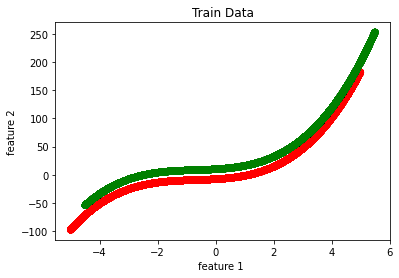

In [684]:
# Visualize
colors = ['red' if i ==0 else 'green' for i in y_train]
plt.scatter(x_train[:,0], x_train[:,1], color = colors)
plt.xlabel('feature 1 ')
plt.ylabel('feature 2')
plt.title('Train Data')

In [685]:
# torch can only train on Variable, so convert them to Variable
x_train, y_train = Variable(x_train), Variable(y_train)

x_train = x_train.cuda()
y_train = y_train.cuda()

In [700]:
net = Net(n_feature=2, n_hidden=10, n_hidden_2=5, n_output=2)     # define the network
# print(net)  # net architecture
net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss

In [701]:
from tqdm.notebook import tqdm

In [707]:
# train the network
losses = []
for t in tqdm(range(5000)):
    prediction = net(x_train)     # input x and predict based on x

    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    losses.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

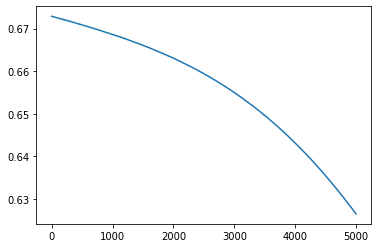

In [708]:
plt.plot(losses)

In [709]:
category_preds = torch.argmax(prediction, dim =1)

In [710]:
accuracy = torch.sum(y_train == category_preds)/len(y_train)

In [711]:
print(accuracy)

tensor(0.7122, device='cuda:0')


# Attack with random search

In [639]:
x_test, y_test = sample_dataset(100000)

In [640]:
x_test, y_test = Variable(x_test), Variable(y_test)

x_test = x_test.cuda()
y_test = y_test.cuda()

In [641]:
prediction_test = net(x_test) 

In [642]:
category_preds_test = torch.argmax(prediction_test, dim =1)

In [643]:
accuracy_test = torch.sum(y_test == category_preds_test)/len(y_test)

In [644]:
accuracy_test

tensor(0.9663, device='cuda:0')

Text(0.5, 1.0, 'Errored predictions on test data')

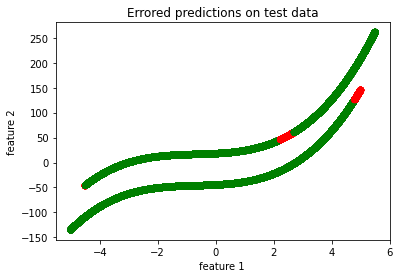

In [645]:
# Visualize
# colors = ['red' if i ==0 else 'green' for i in y_test]
matches = list((y_test == category_preds_test).cpu().long())
colors_2 = ['red' if i ==0 else 'green' for i in matches]
plt.scatter(x_test[:,0].cpu().detach(), x_test[:,1].cpu().detach(), color = colors_2)
plt.xlabel('feature 1 ')
plt.ylabel('feature 2')
plt.title('Errored predictions on test data')

In [658]:
error_positions = torch.where(y_test != category_preds_test)[0]

In [660]:
# error_positions[0]

In [665]:
failed_xs = []
for i in error_positions:
    failed_xs.append(x_test[i][0].item())

In [669]:
np.min(failed_xs)

-4.5

(array([  85.,    0.,    0.,    0.,    0.,    0.,    0., 4675.,    0.,
        1987.]),
 array([-4.5 , -3.55, -2.6 , -1.65, -0.7 ,  0.25,  1.2 ,  2.15,  3.1 ,
         4.05,  5.  ]),
 <BarContainer object of 10 artists>)

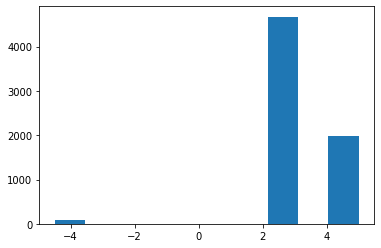

In [670]:
plt.hist(failed_xs)

# Attack with CMA

In [9]:
start_pos = 0.0

In [181]:
import cma

In [182]:
cma.__file__

'/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/cma/__init__.py'

In [ ]:
es = cma.CMAEvolutionStrategy(start_pos, 0.05)

es.(f, verb_disp = True, iterations=15, correct_prediction = category_num)
print(es.predictions)